In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

np.random.seed(123)
tf.random.set_seed(123)

In [ ]:
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

File ‘airline_passengers.csv’ already there; not retrieving.



In [ ]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [ ]:
df['LogPassengers'] = np.log(df['Passengers'])

In [ ]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [ ]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [ ]:
df['DiffLogPassengers'] = df['LogPassengers'].diff()

In [ ]:
# Make supervised dataset
series = df['DiffLogPassengers'].dropna().to_numpy()

T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (133, 10) Y.shape (133,)


In [ ]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [ ]:
# Basic ANN
i = Input(shape=(T,))
x = Dense(32, activation='relu')(i)
x = Dense(1)(x)
model = Model(i, x)

In [ ]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [ ]:
r = model.fit(
  Xtrain,
  Ytrain,
  epochs=150,
  validation_data=(Xtest, Ytest)
)

Epoch 1/150
4/4 [==============================] - 1s 58ms/step - loss: 0.0143 - mae: 0.1035 - val_loss: 0.0113 - val_mae: 0.0901
Epoch 2/150
4/4 [==============================] - 0s 10ms/step - loss: 0.0118 - mae: 0.0936 - val_loss: 0.0098 - val_mae: 0.0845
Epoch 3/150
4/4 [==============================] - 0s 8ms/step - loss: 0.0102 - mae: 0.0860 - val_loss: 0.0089 - val_mae: 0.0818
Epoch 4/150
4/4 [==============================] - 0s 9ms/step - loss: 0.0093 - mae: 0.0802 - val_loss: 0.0085 - val_mae: 0.0792
Epoch 5/150
4/4 [==============================] - 0s 9ms/step - loss: 0.0088 - mae: 0.0769 - val_loss: 0.0082 - val_mae: 0.0767
Epoch 6/150
4/4 [==============================] - 0s 8ms/step - loss: 0.0083 - mae: 0.0740 - val_loss: 0.0078 - val_mae: 0.0742
Epoch 7/150
4/4 [==============================] - 0s 10ms/step - loss: 0.0077 - mae: 0.0711 - val_loss: 0.0075 - val_mae: 0.0716
Epoch 8/150
4/4 [==============================] - 0s 11ms/step - loss: 0.0072 - mae: 0.0685 -

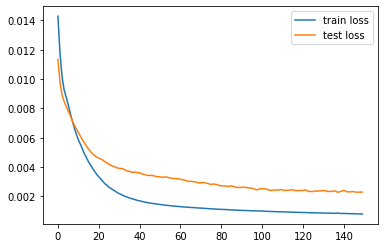

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [ ]:
train_idx[:T+1] = False # first T+1 values are not predictable

In [ ]:
Ptrain = model.predict(Xtrain).flatten()
Ptest = model.predict(Xtest).flatten()

In [ ]:
# Store diff predictions
df.loc[train_idx, 'Diff ANN Train Prediction'] = Ptrain
df.loc[test_idx, 'Diff ANN Test Prediction'] = Ptest

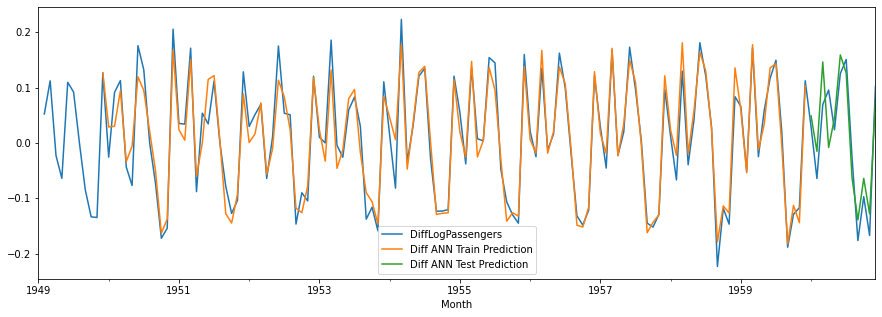

In [ ]:
cols = ['DiffLogPassengers',
        'Diff ANN Train Prediction',
        'Diff ANN Test Prediction']
df[cols].plot(figsize=(15, 5));

In [ ]:
# Needed to compute un-differenced predictions
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

In [ ]:
# Last-known train value
last_train = train.iloc[-1]['LogPassengers']

In [ ]:
# 1-step forecast
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest

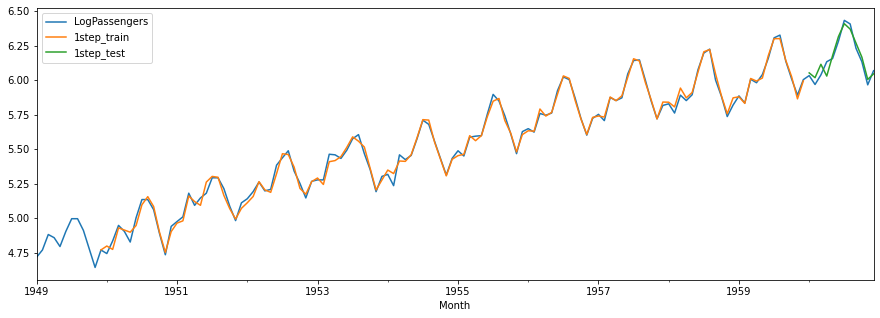

In [ ]:
# plot 1-step forecast
df[['LogPassengers', '1step_train', '1step_test']].plot(figsize=(15, 5));

In [ ]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  p = model.predict(last_x.reshape(1, -1))[0]
  
  # update the predictions list
  multistep_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

In [ ]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

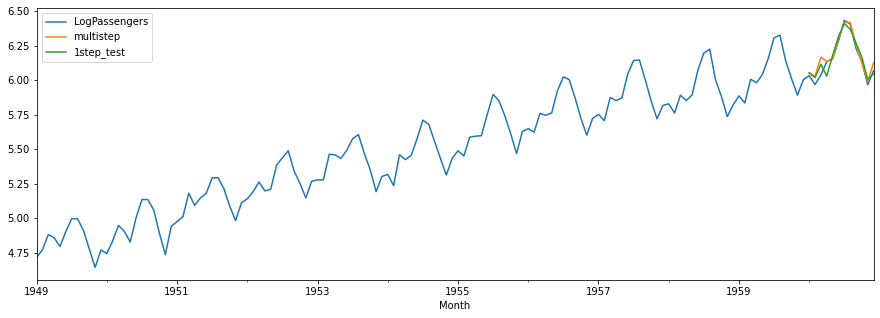

In [ ]:
# plot 1-step and multi-step forecast
df[['LogPassengers', 'multistep', '1step_test']].plot(figsize=(15, 5));

In [ ]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (122, 10) Y.shape (122, 12)


In [ ]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [ ]:
# Basic ANN
i = Input(shape=(Tx,))
x = Dense(32, activation='relu')(i)
x = Dense(Ty)(x)
model = Model(i, x)

In [ ]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [ ]:
r = model.fit(
  Xtrain_m,
  Ytrain_m,
  epochs=150,
  validation_data=(Xtest_m, Ytest_m)
)

Epoch 1/200
4/4 [==============================] - 0s 46ms/step - loss: 0.0169 - val_loss: 0.0111
Epoch 2/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0156 - val_loss: 0.0106
Epoch 3/200
4/4 [==============================] - 0s 8ms/step - loss: 0.0146 - val_loss: 0.0101
Epoch 4/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0137 - val_loss: 0.0098
Epoch 5/200
4/4 [==============================] - 0s 9ms/step - loss: 0.0130 - val_loss: 0.0095
Epoch 6/200
4/4 [==============================] - 0s 9ms/step - loss: 0.0123 - val_loss: 0.0092
Epoch 7/200
4/4 [==============================] - 0s 9ms/step - loss: 0.0118 - val_loss: 0.0091
Epoch 8/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0113 - val_loss: 0.0088
Epoch 9/200
4/4 [==============================] - 0s 9ms/step - loss: 0.0109 - val_loss: 0.0086
Epoch 10/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0105 - val_loss: 0.0084
Epoch 11/200
4/4 [======

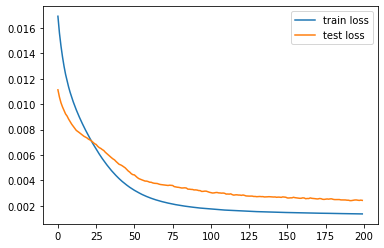

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [ ]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

In [ ]:
Ptrain.shape, Ptest.shape

((121, 12), (1, 12))

In [ ]:
Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

In [ ]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput'] = last_train + \
  np.cumsum(Ptest)

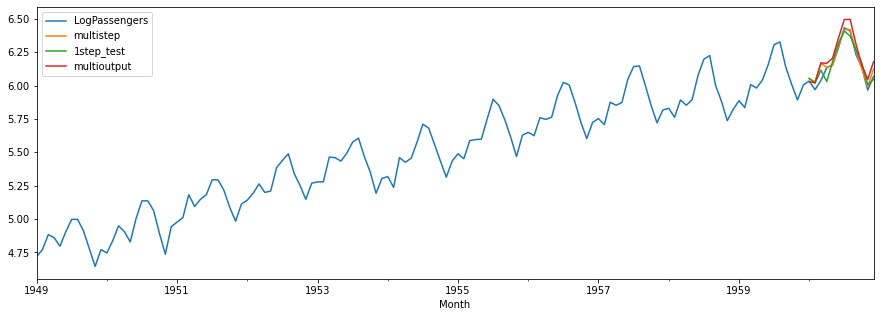

In [ ]:
# plot all forecasts
cols = ['LogPassengers', 'multistep', '1step_test', 'multioutput']
df[cols].plot(figsize=(15, 5));

In [ ]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogPassengers']
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.005068560705661482
multi-output MAPE: 0.01057228182414332


In [ ]:
# Exercise:
# Do you think differencing is unnecessary? Try it!
# Do you think logging is unnecessary? Try it!
# Do you think including more past lags would be useful?
# Have you considered walk-forward validation to optimize hyperparameters?